<a href="https://colab.research.google.com/github/Emily-KD/DS200/blob/main/chpt_16_Inference_for_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade datascience

In [ ]:
from datascience import *
path_data = 'http://personal.psu.edu/drh20/200DS/assets/data/'
import numpy as np
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

#chpt 16 Inference for Regression

Thus far, our analysis of the relation between variables has been purely descriptive. We know how to find the best straight line to draw through a scatter plot. The line is the best in the sense that it has the smallest mean squared error of estimation among all straight lines.

But what if our data were only a sample from a larger population? If in the sample we found a linear relation between the two variables, would the same be true for the population? Would it be exactly the same linear relation? Could we predict the response of a new individual who is not in our sample?

Such questions of inference and prediction arise if we believe that a scatter plot reflects the underlying relation between the two variables being plotted but does not specify the relation completely. For example, a scatter plot of birth weight versus gestational days shows us the precise relation between the two variables in our sample; but we might wonder whether that relation holds true, or almost true, for all babies in the population from which the sample was drawn, or indeed among babies in general.

As always, inferential thinking begins with a careful examination of the assumptions about the data. Sets of assumptions are known as *models*. Sets of assumptions about randomness in roughly linear scatter plots are called *regression models*.

##16.1. A Regression Model

In brief, such models say that the underlying relation between the two variables is perfectly linear; this straight line is the *signal* that we would like to identify. However, we are not able to see the line clearly. What we see are points that are scattered around the line. In each of the points, the signal has been contaminated by *random noise*. Our inferential goal, therefore, is to separate the signal from the noise.

In greater detail, the regression model specifies that the points in the scatter plot are generated at random as follows.

- The relation between $x$ and **the mean of** $y$ is perfectly linear. We cannot see this "true line" but it exists.
- The scatter plot is created by taking points on the line and pushing them off the line vertically, either above or below, as follows:
    - For each $x$, find the corresponding point on the true line (that's the signal), and then generate the noise or error.
    - The errors are drawn at random with replacement from a population of errors that has a normal distribution with mean 0.
    - Create a point whose horizontal coordinate is $x$ and whose vertical coordinate is "the height of the true line at $x$, plus the error".
- Finally, erase the true line from the scatter, and display just the points created.

In [ ]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def scatter_fit(table, x, y):
    plots.scatter(table.column(x), table.column(y), s=20)
    plots.plot(table.column(x), fit(table, x, y), lw=2, color='gold')
    plots.xlabel(x)
    plots.ylabel(y)

Based on this scatter plot, how should we estimate the true line? The best line that we can put through a scatter plot is the regression line. So the regression line is a natural estimate of the true line. 

The simulation below shows how close the regression line is to the true line. The first panel shows how the scatter plot is generated from the true line. The second shows the scatter plot that we see. The third shows the regression line through the plot. The fourth shows both the regression line and the true line.

To run the simulation, call the function `draw_and_compare` with three arguments: the slope of the true line, the intercept of the true line, and the sample size.

Run the simulation a few times, with different values for the slope and intercept of the true line, and varying sample sizes. Because all the points are generated according to the model, you will see that the regression line is a good estimate of the true line if the sample size is moderately large.

In [ ]:
def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    eps = np.random.normal(0, 6, sample_size)
    y = (true_slope*x + true_int) + eps
    tyche = Table().with_columns(
        'x', x,
        'y', y
    )

    plots.figure(figsize=(6, 16))
    plots.subplot(4, 1, 1)
    plots.scatter(tyche['x'], tyche['y'], s=20)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')

    plots.subplot(4, 1, 2)
    plots.scatter(tyche['x'],tyche['y'], s=20)
    plots.title('What We Get to See')

    plots.subplot(4, 1, 3)
    scatter_fit(tyche, 'x', 'y')
    plots.xlabel("")
    plots.ylabel("")
    plots.title('Regression Line: Estimate of True Line')

    plots.subplot(4, 1, 4)
    scatter_fit(tyche, 'x', 'y')
    plots.ylabel("")
    xlims = np.array([np.min(tyche['x']), np.max(tyche['x'])])
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression Line and True Line")

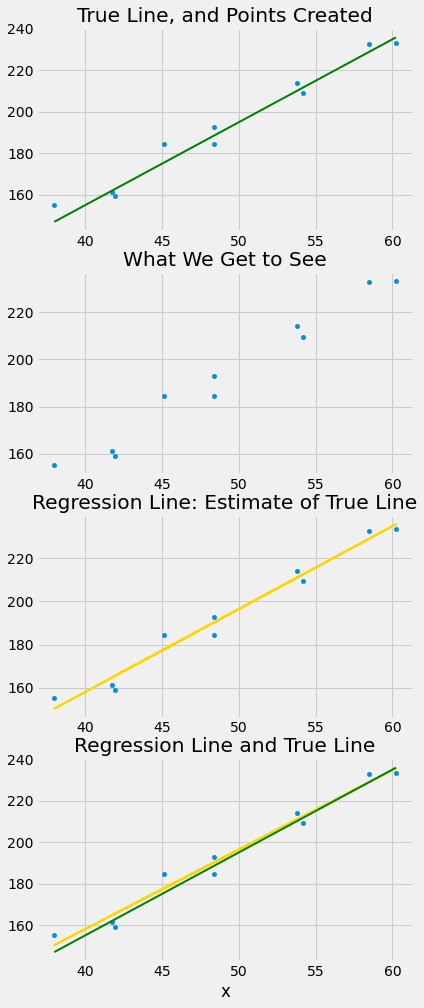

In [ ]:
# The true line,
# the points created,
# and our estimate of the true line.
# Arguments: true slope, true intercept, number of points

draw_and_compare(4, -5, 10)

In reality, of course, we will never see the true line. What the simulation shows that if the regression model looks plausible, and if we have a large sample, then the regression line is a good approximation to the true line.

##16.2. Inference for the True Slope

Our simulations show that if the regression model holds and the sample size is large, then the regression line is likely to be close to the true line. This allows us to estimate the slope of the true line.

We will use our familiar sample of mothers and their newborn babies to develop a method of estimating the slope of the true line. First, let's see if we believe that the regression model is an appropriate set of assumptions for describing the relation between birth weight and the number of gestational days.

In [ ]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

def scatter_fit(table, x, y):
    plots.scatter(table.column(x), table.column(y), s=20)
    plots.plot(table.column(x), fit(table, x, y), lw=2, color='gold')
    plots.xlabel(x)
    plots.ylabel(y)

In [ ]:
def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    eps = np.random.normal(0, 6, sample_size)
    y = (true_slope*x + true_int) + eps
    tyche = Table().with_columns(
        'x', x,
        'y', y
    )

    plots.figure(figsize=(6, 16))
    plots.subplot(4, 1, 1)
    plots.scatter(tyche['x'], tyche['y'], s=20)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')

    plots.subplot(4, 1, 2)
    plots.scatter(tyche['x'],tyche['y'], s=20)
    plots.title('What We Get to See')

    plots.subplot(4, 1, 3)
    scatter_fit(tyche, 'x', 'y')
    plots.xlabel("")
    plots.ylabel("")
    plots.title('Regression Line: Estimate of True Line')

    plots.subplot(4, 1, 4)
    scatter_fit(tyche, 'x', 'y')
    plots.ylabel("")
    xlims = np.array([np.min(tyche['x']), np.max(tyche['x'])])
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression Line and True Line")

In [ ]:
baby = Table.read_table(path_data + 'baby.csv')

In [ ]:
baby.select('Gestational Days', 'Birth Weight').show(3)

Gestational Days,Birth Weight
284,120
282,113
279,128


In [ ]:
baby.select('Maternal Age', 'Birth Weight').show(3)

Maternal Age,Birth Weight
27,120
33,113
28,128


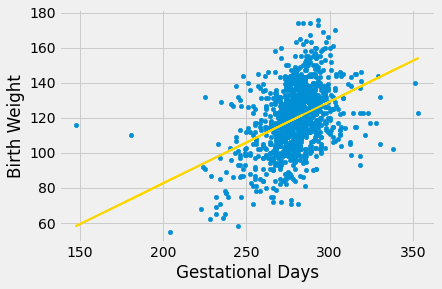

In [ ]:
scatter_fit(baby, 'Gestational Days', 'Birth Weight')

In [ ]:
correlation(baby, 'Gestational Days', 'Birth Weight')

0.4075427933888511

By and large, the scatter looks fairly evenly distributed around the line, though there are some points that are scattered on the outskirts of the main cloud. The correlation is 0.4 and the regression line has a positive slope. 

Does this reflect the fact that the true line has a positive slope? To answer this question, let us see if we can estimate the true slope. We certainly have one estimate of it: the slope of our regression line. That's about 0.47 ounces per day.

In [ ]:
slope(baby, 'Gestational Days', 'Birth Weight')

0.4665568769492152

But had the scatter plot come out differently, the regression line would have been different and might have had a different slope. How do we figure out how different the slope might have been?

We need another sample of points, so that we can draw the regression line through the new scatter plot and find its slope. But from where will get another sample?

You have guessed it – we will *bootstrap our original sample*. That will give us a bootstrapped scatter plot, through which we can draw a regression line.

###16.2.1. Bootstrapping the Scatter Plot
We can simulate new samples by random sampling with replacement from the original sample, as many times as the original sample size. Each of these new samples will give us a scatter plot. We will call that a *bootstrapped scatter plot*, and for short, we will call the entire process *bootstrapping the scatter plot*.

Here is the original scatter diagram from the sample, and four replications of the bootstrap resampling procedure. Notice how the resampled scatter plots are in general a little more sparse than the original. That is because some of the original points do not get selected in the samples.

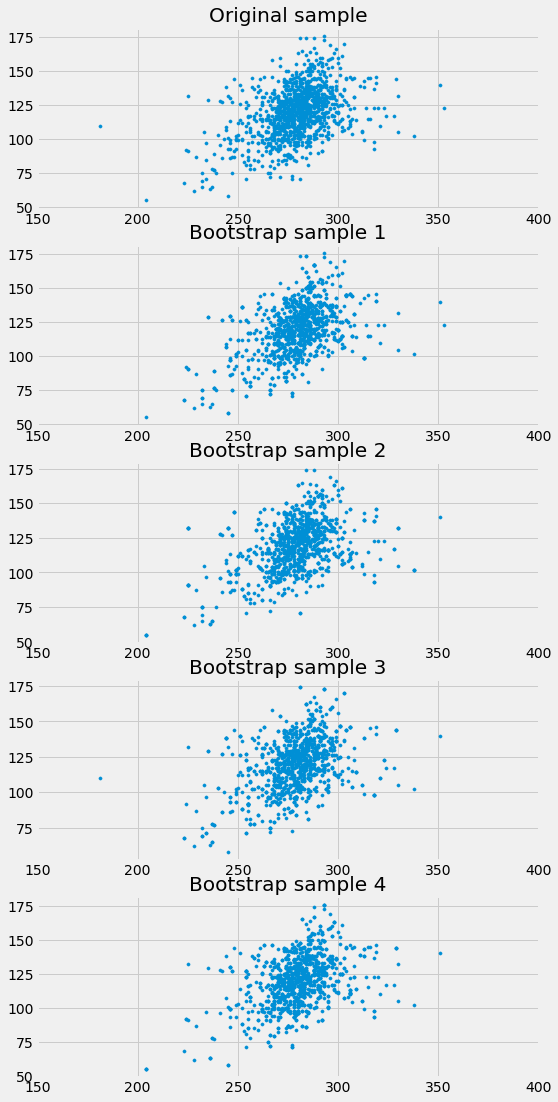

In [ ]:
plots.figure(figsize=(8, 18))
plots.subplot(5, 1, 1)
plots.scatter(baby[1], baby[0], s=10)
plots.xlim([150, 400])
plots.title('Original sample')

for i in np.arange(1, 5, 1):
    plots.subplot(5,1,i+1)
    rep = baby.sample(with_replacement=True)
    plots.scatter(rep[1], rep[0], s=10)
    plots.xlim([150, 400])
    plots.title('Bootstrap sample '+str(i))

###16.2.2. Estimating the True Slope

We can bootstrap the scatter plot a large number of times, and draw a regression line through each bootstrapped plot. Each of those lines has a slope. We can simply collect all the slopes and draw their empirical histogram. Recall that by default, the `sample` method draws at random with replacement, the same number of times as the number of rows in the table. That is, `sample` generates a bootstrap sample by default.

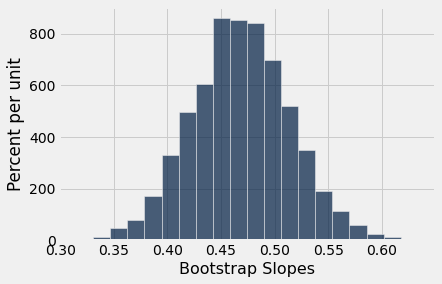

In [ ]:
slopes = make_array()
for i in np.arange(5000):
    bootstrap_sample = baby.sample()
    bootstrap_slope = slope(bootstrap_sample, 'Gestational Days', 'Birth Weight')
    slopes = np.append(slopes, bootstrap_slope)
Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)

We can then construct an approximate 95% confidence interval for the slope of the true line, using the bootstrap percentile method. The confidence interval extends from the 2.5th percentile to the 97.5th percentile of the 5000 bootstrapped slopes.

In [ ]:
left = percentile(2.5, slopes)
right = percentile(97.5, slopes)
left, right

(0.37947083372618684, 0.5608831540403434)

An approximate 95% confidence interval for the true slope extends from about 0.38 ounces per day to about 0.56 ounces per day. 

###16.2.3. A Function to Bootstrap the Slope

Let us collect all the steps of our method of estimating the slope and define a function `bootstrap_slope` that carries them out. Its arguments are the name of the table and the labels of the predictor and response variables, and the desired number of bootstrap replications. In each replication, the function bootstraps the original scatter plot and calculates the slope of the resulting regression line. It then draws the histogram of all the generated slopes and prints the interval consisting of the "middle 95%" of the slopes. 

In [ ]:
def bootstrap_slope(table, x, y, repetitions):
    
    # For each repetition:
    # Bootstrap the scatter, get the slope of the regression line,
    # augment the list of generated slopes
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = table.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(table, x, y)
    
    # Display results
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the true slope:')
    print(left, right)

When we call `bootstrap_slope` to find a confidence interval for the true slope when the response variable is birth weight and the predictor is gestational days, we get an interval very close to the one we obtained earlier: approximately 0.38 ounces per day to 0.56 ounces per day.

Slope of regression line: 0.4665568769492152
Approximate 95%-confidence interval for the true slope:
0.37873093790836615 0.5554624804128101


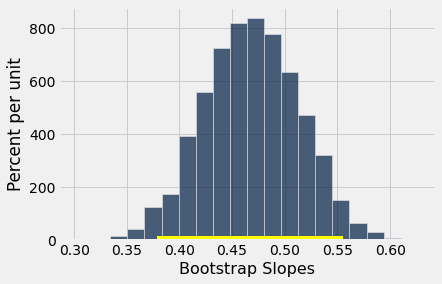

In [ ]:
bootstrap_slope(baby, 'Gestational Days', 'Birth Weight', 5000)

Now that we have a function that automates our process of estimating the slope of the true line in a regression model, we can use it on other variables as well.

For example, let's examine the relation between birth weight and the mother's height. Do taller women tend to have heavier babies?

The regression model seems reasonable, based on the scatter plot, but the correlation is not high. It's just about 0.2.

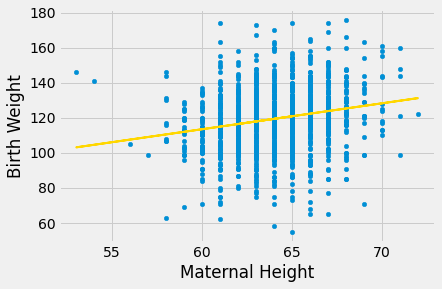

In [ ]:
scatter_fit(baby, 'Maternal Height', 'Birth Weight')

In [ ]:
correlation(baby, 'Maternal Height', 'Birth Weight')

0.20370417718968034

As before, we can use `bootstrap_slope` to estimate the slope of the true line in the regression model.

Slope of regression line: 1.478019351928433
Approximate 95%-confidence interval for the true slope:
1.0451362001415028 1.8964307264748945


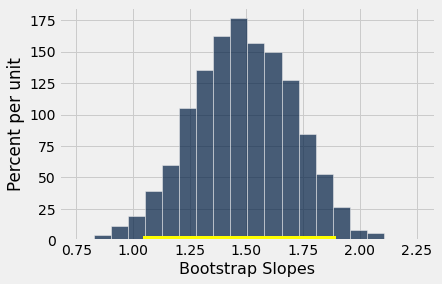

In [ ]:
bootstrap_slope(baby, 'Maternal Height', 'Birth Weight', 5000)

A 95% confidence interval for the true slope extends from about 1 ounce per inch to about 1.9 ounces per inch.

###16.2.4. Could the True Slope Be 0?

Suppose we believe that our data follow the regression model, and we fit the regression line to estimate the true line. If the regression line isn't perfectly flat, as is almost invariably the case, we will be observing some linear association in the scatter plot.

But what if that observation is spurious? In other words, what if the true line was flat – that is, there was no linear relation between the two variables – and the association that we observed was just due to randomness in generating the points that form our sample?

Here is a simulation that illustrates why this question arises. We will once again call the function ``draw_and_compare``, this time requiring the true line to have slope 0. Our goal is to see whether our regression line shows a slope that is not 0.

Remember that the arguments to the function ``draw_and_compare`` are the slope and the intercept of the true line, and the number of points to be generated.

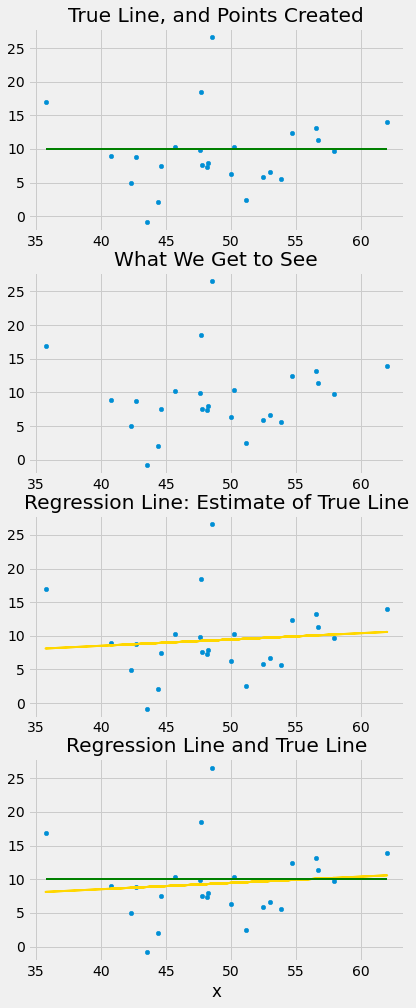

In [ ]:
draw_and_compare(0, 10, 25)

Run the simulation a few times, keeping the slope of the true line 0 each time. You will notice that while the slope of the true line is 0, the slope of the regression line is typically not 0. The regression line sometimes slopes upwards, and sometimes downwards, each time giving us a false impression that the two variables are correlated.

To decide whether or not the slope that we are seeing is real, we would like to test the following hypotheses:

**Null Hypothesis.** The slope of the true line is 0. 

**Alternative Hypothesis.** The slope of the true line is not 0. 

We are well positioned to do this. Since we can construct a 95% confidence interval for the true slope, all we have to do is see whether the interval contains 0. 

If it doesn't, then we can reject the null hypothesis (with the 5% cutoff for the P-value). 

If the confidence interval for the true slope does contain 0, then we don't have enough evidence to reject the null hypothesis. Perhaps the slope that we are seeing is spurious.

Let's use this method in an example. Suppose we try to estimate the birth weight of the baby based on the mother's age. Based on the sample, the slope of the regression line for estimating birth weight based on maternal age is positive, about 0.08 ounces per year. 

In [ ]:
slope(baby, 'Maternal Age', 'Birth Weight')

0.08500766941582513

Though the slope is positive, it's pretty small. The regression line is so close to flat that it raises the question of whether the true line is flat.

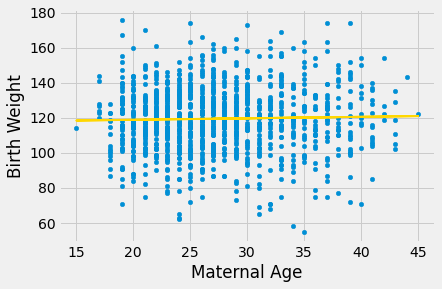

In [ ]:
scatter_fit(baby, 'Maternal Age', 'Birth Weight')

We can use `bootstrap_slope` to estimate the slope of the true line. The calculation shows that an approximate 95% bootstrap confidence interval for the true slope has a negative left end point and a positive right end point – in other words, the interval contains 0. 

Slope of regression line: 0.08500766941582513
Approximate 95%-confidence interval for the true slope:
-0.0992416612373624 0.26972245481951723


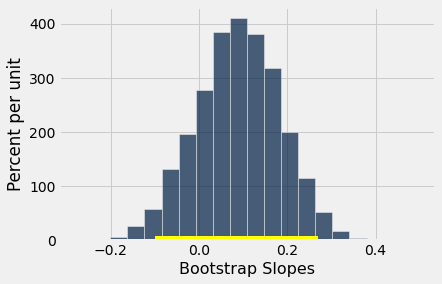

In [ ]:
bootstrap_slope(baby, 'Maternal Age', 'Birth Weight', 5000)

Because the interval contains 0, we cannot reject the null hypothesis that the slope of the true linear relation between maternal age and baby's birth weight is 0. Based on this analysis, it would be unwise to predict birth weight based on the regression model with maternal age as the predictor.

##16.3. Prediction Intervals
**Important warning: This entire section is only about practicingthee mean birth weight of all baabies born at $x$ days. It is NOT about predicting an indivisual birth weight of a single baby born at $x$ days.**
This is becasue this section ONLY takes account of the variability in possible regression lines, NOT the variablility of an indivisual above or below the true line relating $x$ to the mean of $y$.** 
One of the primary uses of regression is to make predictions for a new individual who was not part of our original sample but is similar to the sampled individuals. In the language of the model, we want to estimate $y$ for a new value of $x$.

Our estimate is the height of the true line at $x$. Of course, we don't know the true line. What we have as a substitute is the regression line through our sample of points.

The **fitted value** at a given value of $x$ is the regression estimate of $y$ based on that value of $x$. In other words, the fitted value at a given value of $x$ is the height of the regression line at that $x$.

In [ ]:
baby = Table.read_table(path_data + 'baby.csv')

In [ ]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

def scatter_fit(table, x, y):
    plots.scatter(table.column(x), table.column(y), s=20)
    plots.plot(table.column(x), fit(table, x, y), lw=2, color='gold')
    plots.xlabel(x)
    plots.ylabel(y)

Suppose we try to predict a baby's birth weight based on the number of gestational days. As we saw in the previous section, the data fit the regression model fairly well and a 95% confidence interval for the slope of the true line doesn't contain 0. So it seems reasonable to carry out our prediction.

The figure below shows where the prediction lies on the regression line. The red line is at $x = 300$.

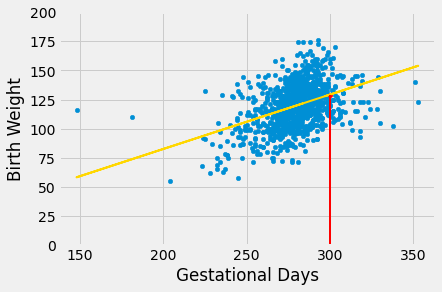

In [ ]:
scatter_fit(baby, 'Gestational Days', 'Birth Weight')
s = slope(baby, 'Gestational Days', 'Birth Weight')
i = intercept(baby, 'Gestational Days', 'Birth Weight')
fit_300 = s*300 + i
plots.scatter(300, fit_300, color='red', s=20)
plots.plot([300,300], [0, fit_300], color='red', lw=2)
plots.ylim([0, 200]);

The height of the point where the red line hits the regression line is the fitted value at 300 gestational days. 

The function `fitted_value` computes this height. Like the functions `correlation`, `slope`, and `intercept`, its arguments include the name of the table and the labels of the $x$ and $y$ columns. But it also requires a fourth argument, which is the value of $x$ at which the estimate will be made.

In [ ]:
def fitted_value(table, x, y, given_x):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * given_x  + b

The fitted value at 300 gestational days is about 129.2 ounces. In other words, for a pregnancy that has a duration of 300 gestational days, our estimate for the baby's weight is about 129.2 ounces.

In [ ]:
fit_300 = fitted_value(baby, 'Gestational Days', 'Birth Weight', 300)
fit_300

129.2129241703143

###16.3.1. The Variability of the Prediction

We have developed a method making one prediction of a new baby's birth weight based on the number of gestational days, using the data in our sample. But as data scientists, we know that the sample might have been different. Had the sample been different, the regression line would have been different too, and so would our prediction. To see how good our prediction is, we must get a sense of how variable the prediction can be.

To do this, we must generate new samples. We can do that by bootstrapping the scatter plot as in the previous section. We will then fit the regression line to the scatter plot in each replication, and make a prediction based on each line. The figure below shows 10 such lines, and the corresponding predicted birth weight at 300 gestational days.

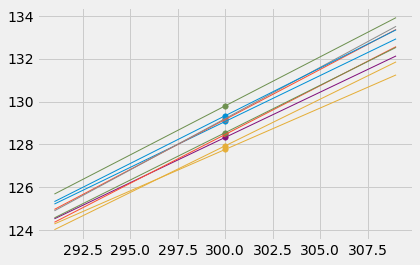

In [ ]:
x = 300

lines = Table(['slope','intercept'])
for i in range(10):
    rep = baby.sample(with_replacement=True)
    a = slope(rep, 'Gestational Days', 'Birth Weight')
    b = intercept(rep, 'Gestational Days', 'Birth Weight')
    lines.append([a, b])

lines['prediction at x='+str(x)] = lines.column('slope')*x + lines.column('intercept')

xlims = np.array([291, 309])
left = xlims[0]*lines[0] + lines[1]
right = xlims[1]*lines[0] + lines[1]
fit_x = x*lines['slope'] + lines['intercept']

for i in range(10):
    plots.plot(xlims, np.array([left[i], right[i]]), lw=1)
    plots.scatter(x, fit_x[i], s=30)

The predictions vary from one line to the next. The table below shows the slope and intercept of each of the 10 lines, along with the prediction. 

In [ ]:
lines

slope,intercept,prediction at x=300
0.429036,0.357129,129.068
0.467364,-11.047,129.162
0.387029,11.6513,127.76
0.458173,-7.65423,129.798
0.47908,-14.5214,129.202
0.422966,1.43345,128.323
0.44611,-4.49671,129.336
0.456169,-8.39062,128.46
0.435751,-2.79556,127.93
0.442743,-4.27745,128.545


###16.3.2. Bootstrap Prediction Interval

If we increase the number of repetitions of the resampling process, we can generate an empirical histogram of the predictions. This will allow us to create an interval of predictions, using the same percentile method that we used create a bootstrap confidence interval for the slope.

Let us define a function called ``bootstrap_prediction`` to do this. The function takes five arguments:
- the name of the table
- the column labels of the predictor and response variables, in that order
- the value of $x$ at which to make the prediction
- the desired number of bootstrap repetitions

In each repetition, the function bootstraps the original scatter plot and finds the predicted value of $y$ based on the specified value of $x$. Specifically, it calls the function `fitted_value` that we defined earlier in this section to find the fitted value at the specified $x$.

Finally, it draws the empirical histogram of all the predicted values, and prints the interval consisting of the "middle 95%" of the predicted values. It also prints the predicted value based on the regression line through the original scatter plot.

In [ ]:
# Bootstrap prediction of variable y at new_x
# Data contained in table; prediction by regression of y based on x
# repetitions = number of bootstrap replications of the original scatter plot

def bootstrap_prediction(table, x, y, new_x, repetitions):
    
    # For each repetition:
    # Bootstrap the scatter; 
    # get the regression prediction at new_x; 
    # augment the predictions list
    predictions = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = table.sample()
        bootstrap_prediction = fitted_value(bootstrap_sample, x, y, new_x)
        predictions = np.append(predictions, bootstrap_prediction)
        
    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)
    
    # Prediction based on original sample
    original = fitted_value(table, x, y, new_x)
    
    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Height of regression line at x='+str(new_x)+':', original)
    print('Approximate 95%-confidence interval:')
    print(left, right)

Height of regression line at x=300: 129.2129241703143
Approximate 95%-confidence interval:
127.24188703362213 131.33234515215622


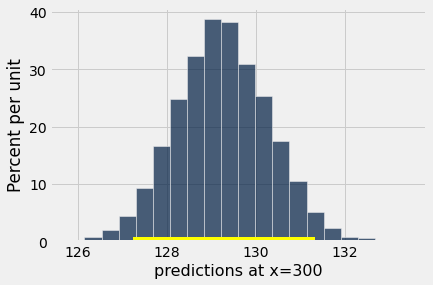

In [ ]:
bootstrap_prediction(baby, 'Gestational Days', 'Birth Weight', 300, 5000)

The figure above shows a bootstrap empirical histogram of the predicted birth weight of a baby at 300 gestational days, based on 5,000 repetitions of the bootstrap process. The empirical distribution is roughly normal. 

An approximate 95% prediction interval of scores has been constructed by taking the "middle 95%" of the predictions, that is, the interval from the 2.5th percentile to the 97.5th percentile of the predictions. The interval ranges from about 127 to about 131. The prediction based on the original sample was about 129, which is close to the center of the interval.

###16.3.3. The Effect of Changing the Value of the Predictor

The figure below shows the histogram of 5,000 bootstrap predictions at 285 gestational days. The prediction based on the original sample is about 122 ounces, and the interval ranges from about 121 ounces to about 123 ounces. 

Height of regression line at x=285: 122.21457101607608
Approximate 95%-confidence interval:
121.18388727161933 123.27216401041271


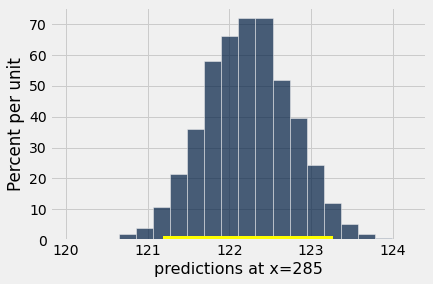

In [ ]:
bootstrap_prediction(baby, 'Gestational Days', 'Birth Weight', 285, 5000)

Notice that this interval is narrower than the prediction interval at 300 gestational days. Let us investigate the reason for this.

The mean number of gestational days is about 279 days: 

In [ ]:
np.mean(baby.column('Gestational Days'))

279.1013628620102

So 285 is nearer to the center of the distribution than 300 is. Typically, the regression lines based on the bootstrap samples are closer to each other near the center of the distribution of the predictor variable. Therefore all of the predicted values are closer together as well. This explains the narrower width of the prediction interval. 

You can see this in the figure below, which shows predictions at $x = 285$ and $x = 300$ for each of ten bootstrap replications. Typically, the lines are farther apart at $x = 300$ than at $x = 285$, and therefore the predictions at $x = 300$ are more variable.

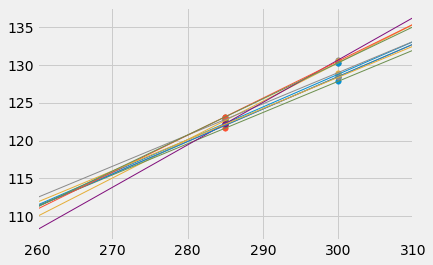

In [ ]:
x1 = 300
x2 = 285

lines = Table(['slope','intercept'])
for i in range(10):
    rep = baby.sample(with_replacement=True)
    a = slope(rep, 'Gestational Days', 'Birth Weight')
    b = intercept(rep, 'Gestational Days', 'Birth Weight')
    lines.append([a, b])

xlims = np.array([260, 310])
left = xlims[0]*lines[0] + lines[1]
right = xlims[1]*lines[0] + lines[1]
fit_x1 = x1*lines['slope'] + lines['intercept']
fit_x2 = x2*lines['slope'] + lines['intercept']

plots.xlim(xlims)
for i in range(10):
    plots.plot(xlims, np.array([left[i], right[i]]), lw=1)
    plots.scatter(x1, fit_x1[i], s=30)
    plots.scatter(x2, fit_x2[i], s=30)

####16.3.3.1. Words of caution 

All of the predictions and tests that we have performed in this chapter assume that the regression model holds. Specifically, the methods assume that the scatter plot resembles points generated by starting with points that are on a straight line and then pushing them off the line by adding random normal noise.

If the scatter plot does not look like that, then perhaps the model does not hold for the data. If the model does not hold, then calculations that assume the model to be true are not valid.

Therefore, we must first decide whether the regression model holds for our data, before we start making predictions based on the model or testing hypotheses about parameters of the model. A simple way is to do what we did in this section, which is to draw the scatter diagram of the two variables and see whether it looks roughly linear and evenly spread out around a line. We should also run the diagnostics we developed in the previous section using the residual plot.